### Plotting and Analyzing Learned Parameters of Trained BINN
This notebook plots the learned parameters from trained BINNs.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter

import sys
sys.path.append('../')

from Modules.Utils.Imports import *
from Modules.Models.BuildBINNs import NNComponentsCV
from Modules.Utils.ModelWrapper import ModelWrapper

import Modules.Utils.PDESolver as PDESolver
import Modules.Loaders.DataFormatter as DF
from utils import get_case_name, lasso_parameter_fitting, plot_loss_convergence
import seaborn as sns
from sklearn import linear_model

# helper functions
def to_torch(ndarray):
    arr = torch.tensor(ndarray, dtype=torch.float)
    arr.requires_grad_(True)
    arr = arr.to(device)
    return arr

def to_numpy(x):
    return x.detach().cpu().numpy()

device = torch.device(GetLowestGPU(pick_from=[0,1,2,3]))

Device set to cuda:3


In [2]:
# instantiate BINN model parameters and path
path = '../Data/covasim_data/drums_data/'
population = int(200e3)
test_prob = 0.1
trace_prob = 0.3
keep_d = True
retrain = False
dynamic = True
masking = 3
parallelb = True
n_runs = 1024
chi_type = 'piecewise'

In [3]:
case_name = get_case_name(population, test_prob, trace_prob, keep_d, dynamic=dynamic, chi_type=chi_type)
if not masking==0:
    if masking==1:
        case_name = case_name + '_maskingthresh'
    elif masking==2:
        case_name = case_name + '_maskinguni'
    elif masking==3:
        case_name = case_name + '_maskingnorm'

In [4]:
params = DF.load_covasim_data(path, population, test_prob, trace_prob, keep_d, case_name + '_' + str(n_runs), plot=False)

In [7]:
if parallelb:
    data_smooth = params['data']
else:
    data_smooth = params['data']
    data_smooth = np.mean(data_smooth, axis=1)
    data_smooth = (data_smooth / params['population'])
    
N = len(data_smooth) - 2
u = to_torch(data_smooth[1:N+1,:])

t_max_real = N + 1
t = np.arange(N)[:,None] + 1
params.pop('data')

if masking>0:
    avg_masking = params['avg_masking']
tracing_array = params['tracing_array']

In [8]:
dmethod = 'savgol' # 'savgol', 'cfd'

# central differences numerical differentiation
if dmethod=='cfd':
    u_front = data_smooth[:N,:]
    u_back = data_smooth[2:,:]
    ut = to_torch((u_back - u_front) / 2.)
    
# savgol method
elif dmethod=='savgol':
    ut = to_torch(savgol_filter(data_smooth, 15, 4, deriv=1, axis=0))[1:N+1,:]

In [9]:
# split into train/val and convert to torch
split = int(0.8*N)
# generate shuffled array of indices from 0 to N-1
p = np.random.permutation(N)[:,None]

u_tensor = torch.cat([u[:,:,None], ut[:,:,None]], axis=2)

# asssign x_train to be random days from 1 to N-2 of size int(0.8 * N)
x_train = to_torch((p[:split] + 1)) / t_max_real
# assign y_train to be values corresponding to x_train of size int(0.8 * N)
y_train = to_torch(u[(p[:split]).flatten()])
# assign x_val to be randomly shuffled days from 1 to N-2 of size int(0.2 * N)
x_val = to_torch((p[split:] + 1)) / t_max_real
# assign y_val to be values corresponding to y_val of size int(0.2 * N)
y_val = to_torch(u[(p[split:]).flatten()])

/home/mars/venv3/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [11]:
# mydir = '../models/covasim/denoised/2023-07-05_23-03-30'      # no masking
# mydir = '../models/covasim/denoised/2023-07-06_08-58-57'      # masking
# mydir = '../models/covasim/denoised/2023-07-06_09-38-51'      # no masking, piecewise, 10,000 epochs, lr=9e-4
# mydir = '../models/covasim/denoised/2023-07-06_10-36-09'      # no masking, piecewise, 10,000 epochs, lr=1e-5
# mydir = '../models/covasim/denoised/2023-07-06_12-01-22'      # masking, piecewise, 10,000 epochs, lr=1e-5
# mydir = '../models/covasim/denoised/2023-07-06_13-05-26'      # no masking, piecewise, 10,000 epochs, lr=1e-5, 3 layers deep
# mydir = '../models/covasim/denoised/2023-07-06_18-50-10'      # masking, piecewise, 10,000 epochs, lr=1e-5, trimmed
# mydir = '../models/covasim/denoised/2023-07-11_14-59-05'        # norm masking, piecewise, 30,000 epochs, lr=1e-5, savbol differentiation
# mydir = '../models/covasim/denoised/2023-07-11_15-22-17'        # no masking, piecewise, 30,000 epochs, lr=1e-5, sablov diff
mydir = '../models/covasim/denoised/2023-07-15_16-27-03'        # norm masking, piecewise, 500,000 epochs, lr=5e-6, sablov diff

# initialize model hyperparameters and architecture type
mask_input = True
eta_deep = True
beta_deep = True
tau_deep = False

binn = NNComponentsCV(params, 
                      u_tensor, 
                      t_max_real,
                      tracing_array, 
                      keep_d=keep_d, 
                      chi_type=chi_type, 
                      mask_input=mask_input,
                      eta_deep=eta_deep,
                      beta_deep=beta_deep,
                      tau_deep=tau_deep).to(device)
parameters = binn.parameters()
model = ModelWrapper(binn, None, None, save_name=os.path.join(mydir, case_name))

In [12]:
if retrain:
    model.save_name += '_retrain'
model.save_name += '_best_val'
model.load(model.save_name + '_model', device=device)
save_path = model.save_folder
# grab initial condition
u0 = data_smooth[0, :].copy()

In [13]:
# if not folder for plots exists, make them
if not os.path.exists(model.save_folder + '\\eta_plots'):
    os.makedirs(os.path.join(model.save_folder, 'eta_plots'))
    os.makedirs(os.path.join(model.save_folder, 'beta_plot'))
    os.makedirs(os.path.join(model.save_folder, 'tau_plot'))

In [11]:
# grab value ranges
yita_lb, yita_ub = model.model.yita_lb, model.model.yita_ub
beta_lb, beta_ub = model.model.beta_lb, model.model.beta_ub
tau_lb, tau_ub = model.model.tau_lb, model.model.tau_ub

In [12]:
# learned contact_rate function
def contact_rate(u):
    res = binn.eta_func(to_torch(u))
    return to_numpy(res)
# learned tracing rate function
def beta(u):
    res = binn.beta_func(to_torch(u))
    return to_numpy(res)
# learned diagnoses rate of quarantined individuals
def tau(u):
    res = binn.tau_func(to_torch(u))
    return to_numpy(res)

In [13]:
#%% visualization for eta
s_min, s_max = data_smooth[:,0].min(), data_smooth[:,0].max()
a_min, a_max = data_smooth[:,3].min(), data_smooth[:,3].max()
y_min, y_max = data_smooth[:,4].min(), data_smooth[:,4].max()
m_min, m_max = avg_masking.min(), avg_masking.max()
say_min, say_max = (data_smooth[:,0] + data_smooth[:,3] + data_smooth[:,4]).min(), (data_smooth[:,0] + data_smooth[:,3] + data_smooth[:,4]).max()
chi_min, chi_max = 0.0, params['eff_ub']

FileNotFoundError: [Errno 2] No such file or directory: '../models/covasim/denoised/2023-07-11_15-22-17/200000_0.1_0.3_dynamic_piecewise\\eta_plots/200000_0.1_0.3_dynamic_piecewise_parameter_NN_eta_DRUMS.png'

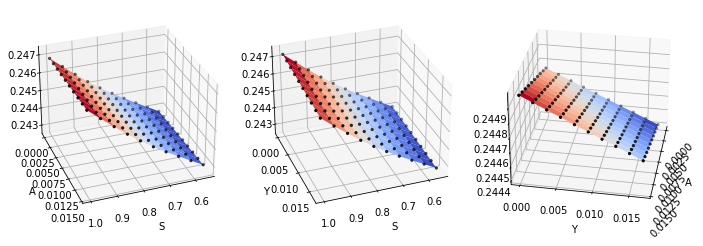

In [14]:
# grid for inputs S, A
a_grid = np.linspace(s_min, s_max, 10)
# grid for inputs S, Y
b_grid = np.linspace(a_min, a_max, 10)
# grid for inputs A, Y
c_grid = np.linspace(y_min, y_max, 10)
# grid for inputs with M
d_grid = np.linspace(m_min, m_max, 10)

labels = ['S', 'A', 'Y', 'M']
fig = plt.figure(figsize=(10,7))
# for each of the 3 input combinations
for i in range(6):
    if i == 0:
        X, Y = np.meshgrid(a_grid, b_grid)
        Z, M = np.ones_like(X) * c_grid.mean(), np.ones_like(X) * d_grid.mean()
        # set x and y labels to S and A
        x_label, y_label = labels[0], labels[1]
    elif i == 1:
        X, Z = np.meshgrid(a_grid, c_grid)
        Y, M = np.ones_like(X) * b_grid.mean(), np.ones_like(X) * d_grid.mean()
        # set x and y labels to S and Y
        x_label, y_label = labels[0], labels[2]
    elif i==2:
        Y, Z = np.meshgrid(b_grid, c_grid)
        X, M = np.ones_like(Y) * a_grid.mean(), np.ones_like(Y) * d_grid.mean()
        # set x and y labels to A and Y
        x_label, y_label = labels[1], labels[2]
    elif i==3:
        X, M = np.meshgrid(a_grid, d_grid)
        Y, Z = np.ones_like(X) * b_grid.mean(), np.ones_like(X) * c_grid.mean()
        # set x and y labels to S and M
        x_label, y_label = labels[0], labels[3]
    elif i==4:
        Y, M = np.meshgrid(b_grid, d_grid)
        X, Z = np.ones_like(Y) * a_grid.mean(), np.ones_like(Y) * c_grid.mean()
        # set x and y labels to A and M
        x_label, y_label = labels[1], labels[3]
    elif i==5:
        Z, M = np.meshgrid(c_grid, d_grid)
        X, Y = np.ones_like(Z) * a_grid.mean(), np.ones_like(Z) * b_grid.mean()
        # set x and y labels to S and M
        x_label, y_label = labels[2], labels[3]

    # grid of S, A, Y values
    u_grid = np.stack([np.ravel(X), np.ravel(Y), np.ravel(Z), np.ravel(M)], axis=1)
    # result of evaluating eta with inputs S, A, Y
    res = contact_rate(u_grid)
    # transfom eta(S, A, Y) into the interval previously defined
    res = yita_lb + (yita_ub - yita_lb) * res
    res = res[:,0].reshape(X.shape)
    res = np.round(res, decimals=6)
    
    ax = fig.add_subplot(2, 3, i + 1, projection='3d')
    if i==0:
        ax.plot_surface(X, Y, res, cmap=cm.coolwarm, alpha=1)
        ax.scatter(X.reshape(-1), Y.reshape(-1), res.reshape(-1), s=5, c='k')
        ax.view_init(30,70)
    elif i==1:
        ax.plot_surface(X, Z, res, cmap=cm.coolwarm, alpha=1)
        ax.scatter(X.reshape(-1), Z.reshape(-1), res.reshape(-1), s=5, c='k')
        ax.view_init(30,70)
    elif i==2:
        ax.plot_surface(Y, Z, res, cmap=cm.coolwarm, alpha=1)
        ax.scatter(Y.reshape(-1), Z.reshape(-1), res.reshape(-1), s=5, c='k')
        plt.setp(ax.get_xticklabels(), rotation=45) # , ha="right", rotation_mode="anchor"
        ax.view_init(30,10)
    elif i==3:
        ax.plot_surface(X, M, res, cmap=cm.coolwarm, alpha=1)
        ax.scatter(X.reshape(-1), M.reshape(-1), res.reshape(-1), s=5, c='k')
        ax.view_init(30,70)
    elif i==4:
        ax.plot_surface(Y, M, res, cmap=cm.coolwarm, alpha=1)
        ax.scatter(Y.reshape(-1), M.reshape(-1), res.reshape(-1), s=5, c='k')
        ax.view_init(30,70)
    elif i==5:
        ax.plot_surface(Z, M, res, cmap=cm.coolwarm, alpha=1)
        ax.scatter(Z.reshape(-1), M.reshape(-1), res.reshape(-1), s=5, c='k')
        ax.view_init(30,70)

    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    
plt.tight_layout(pad=2)
plt.savefig(os.path.join(save_path + '/eta_plots', case_name + '_parameter_NN_eta_DRUMS' + '.png'), dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
#%% visualization for beta
chi_min, chi_max = 0.05, params['eff_ub']
# chi_grid = np.linspace(chi_min, chi_max, 10)

a_grid = np.linspace(say_min, say_max, 10) # S + A + Y
b_grid = np.linspace(chi_min, chi_max, 10)
labels = ['S + A + Y', r'$h(t)$']

X, Y = np.meshgrid(a_grid, b_grid)
x_label, y_label = labels[0], labels[1]
u_grid = np.stack([np.ravel(X), np.ravel(Y)], axis=1)
res = beta(u_grid) * params['n_contacts'] # * u_grid[:, [1]] *
res = res[:,0].reshape(X.shape)
res = np.round(res, decimals=6)
# res = beta_lb + (beta_ub - beta_lb) * res

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.plot_surface(X, Y, res, cmap=cm.coolwarm, alpha=1)
ax.scatter(X.reshape(-1), Y.reshape(-1), res.reshape(-1), s=5, c='k')
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
ax.set_zticks(np.arange(0,40.1, 5), np.arange(0,40.1, 5))
ax.set_title(r'$\beta(t)h(t)$')
ax.view_init(15,120)
plt.tight_layout(pad=2)

plt.savefig(os.path.join(save_path + '\\beta_plot', case_name + '_parameter_NN_beta_DRUMS' + '.png'), dpi=300, bbox_inches='tight' )
plt.show()
plt.close()

In [ ]:
#%% visualization for tau

a_grid = np.linspace(a_min, a_max, 10)
b_grid = np.linspace(y_min, y_max, 10)
labels = ['A', 'Y']

X, Y = np.meshgrid(a_grid, b_grid)
x_label, y_label = labels[0], labels[1]
u_grid = np.stack([np.ravel(X), np.ravel(Y)], axis=1)
res = tau(u_grid)
res = res[:,0].reshape(X.shape)
res = tau_lb + (tau_ub - tau_lb) * res # scaling
res = np.round(res, decimals=4)

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.plot_surface(X, Y, res, cmap=cm.coolwarm, alpha=1)
ax.scatter(X.reshape(-1), Y.reshape(-1), res.reshape(-1), s=5, c='k')
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
ax.set_title(r'$\tau(t)$')
plt.tight_layout(pad=2)
plt.savefig(os.path.join(save_path + '\\tau_plot', case_name + '_parameter_NN_tau_DRUMS' + '.png'), dpi=300, bbox_inches='tight')
plt.show()
plt.close()